## PyTorch 학습 레벨 2 - 002
---

### 순서
- Tensor
- _~~Augograd~~_
- DataSet, DataLoader
- Transform

In [1]:
import numpy as np
import torch

### Autograd
- Automatic gradient calculating API 
- forward(Forward Propagation: 순전파)와 backward(Backward Propagation: 역전파)가 가능하게 해줌
- [참조](https://tutorials.pytorch.kr/beginner/basics/autogradqs_tutorial.html)

```python
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
```

<img src="https://tutorials.pytorch.kr/_images/comp-graph.png" width="700" style="background:white;">


- 이 신경망에서, w(가중치)와 b(절편편)는 최적화를 해야 하는 매개변수
    - requires_grad=True 를 사용해서 추적가능
- 변화도(Gradient) 계산, 변화도 추적
- 다음번 노드 계산에서 사용할 때, 좀더 나은 값을 변경(조정)되어 대입되어야 함 -> 역전파


In [5]:
import torch
import torch.nn.functional

x = torch.ones(5)   # 입력 텐서 x는 5개의 1
y = torch.zeros(3)  # 예상 출력 y는 3개의 0
w = torch.randn(5, 3, requires_grad=True)   # 가중치 w는 5x3 크기의 랜덤 텐서, 학습을 위해 미분 가능
b = torch.randn(3, requires_grad=True)      # 편향 b는 3개의 랜덤 값, 학습을 위해 미분 가능
z = torch.matmul(x, w) + b                  # 입력 x와 가중치 w를 행렬 곱한 후, 편향 b를 더함

# 로짓 z와 예상 출력 y 사이의 이진 교차 엔트로피 손실 계산
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [10]:
x, y, w, b, z, loss

(tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 0.]),
 tensor([[-1.0243,  0.2566, -0.9145],
         [ 0.4071,  1.5941,  1.0600],
         [-0.3276, -0.5151,  0.4659],
         [ 1.2927, -0.0337,  0.5805],
         [ 0.6181, -0.3403,  0.7627]], requires_grad=True),
 tensor([ 0.9699, -1.6834, -1.5001], requires_grad=True),
 tensor([ 1.9359, -0.7219,  0.4544]),
 tensor(1.1375, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))

In [3]:
print('Gradient function for z = ', z.grad_fn)   # z 텐서의 기울기 함수(역전파 계산 함수)를 출력
print('Gradient function for loss = ', loss.grad_fn)

Gradient function for z =  <AddBackward0 object at 0x00000216E940AB00>
Gradient function for loss =  <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000216CB093A00>


#### Gradient(변화도) 계산
- 신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산
- ``x`` 와 ``y`` 의 일부 고정값에서 $\frac{\partial loss}{\partial w}$와 $\frac{\partial loss}{\partial b}$ 가 필요

In [4]:
loss.backward(retain_graph=True)        # 손실(loss)의 역전파를 계산
# backward() 함수는 그래디언트를 계산하는데 사용, 자동 미분을 통해 손실 함수에 대한 모든 가중치의 기울기를 계산
# retain_graph=True, 그래프가 메모리에 남아있어 후속 연산을 위한 추가적인 역전파 계산이 가능
# 이 옵션은 한 번의 backward 호출로 여러 번의 역전파를 수행하려는 경우

print(w.grad)
print(b.grad)

tensor([[0.0332, 0.0042, 0.3287],
        [0.0332, 0.0042, 0.3287],
        [0.0332, 0.0042, 0.3287],
        [0.0332, 0.0042, 0.3287],
        [0.0332, 0.0042, 0.3287]])
tensor([0.0332, 0.0042, 0.3287])


In [6]:
loss.backward(retain_graph=True)
print(w.grad)
print(b.grad)

tensor([[0.2913, 0.1090, 0.2039],
        [0.2913, 0.1090, 0.2039],
        [0.2913, 0.1090, 0.2039],
        [0.2913, 0.1090, 0.2039],
        [0.2913, 0.1090, 0.2039]])
tensor([0.2913, 0.1090, 0.2039])


In [7]:
loss.backward(retain_graph=True)
print(w.grad)
print(b.grad)

tensor([[0.5826, 0.2180, 0.4078],
        [0.5826, 0.2180, 0.4078],
        [0.5826, 0.2180, 0.4078],
        [0.5826, 0.2180, 0.4078],
        [0.5826, 0.2180, 0.4078]])
tensor([0.5826, 0.2180, 0.4078])


- loss.backward() 가 호출이 될 때 마다 동일한 크기의 gradient 값이 추가로 가산됨

#### 변화도 추적 멈추기
- `requires_grad=True`인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원
- 단, 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우, torch.no_grad() 활용
- 동일한 결과를 얻는 다른 방법은 텐서에 `detach()` 메소드를 사용 

In [9]:
z = torch.matmul(x, w)+b        # 입력 x와 가중치 w를 행렬 곱한 후, 편향 b를 더함
print(z.requires_grad)          # z 텐서가 기울기를 추적해야 하는지 확인

with torch.no_grad():           # 이 블록 내 텐서 연산이 기울기 추적 하지않게 설정
  z = torch.matmul(x, w)+b      # 기울기 추적을 하지 않고 연산
  print(z.requires_grad)        # 'no_grad' 블록 내에서 연산된 z는 기울기를 추적하지 않음, 따라서 False가 출력

print(z.requires_grad)          # z는 'no_grad' 블록 밖에서 사용, 기울기 추적 여부가 False로 출력

True
False
False


#### 선택적으로 읽기(Optional Reading): 텐서 변화도와 야코비안 곱(Jacobian Product)
- 대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 함
- 그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌 **야코비안 곱(Jacobian product)** 을 계산


$\vec{x}=\langle x_1,\dots,x_n\rangle$ 이고, $\vec{y}=\langle y_1,\dots,y_m\rangle`$ 일 때 벡터 함수 $\vec{y}=f(\vec{x})$에서 $\vec{x}$에 대한 $\vec{y}$의 변화도는 **야코비안 행렬(Jacobian matrix)**로 제시:

$$J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right) $$

- 야코비안 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 $v=(v_1 \dots v_m)$ 에 대한 **야코비안 곱(Jacobian Product)**  $v^T\cdot J$ 을 계산
- 이 과정은 $v$ 를 인자로 ``backward`` 를 호출하면 끝. 단, $v$의 크기는 곱(product)을 계산하려고 하는 원래 텐서의 크기와 동일해야 함.

In [14]:
inp = torch.eye(5, requires_grad=True)  # 5x5 크기 단위 행렬을 생성, 기울기 추적 설정
print(f'Input tensor :\n{inp}')
out = (inp + 1).pow(2)  # inp에 1을 더하고, 그 값을 제곱하여 out 텐서 생성
print(f'Output tensor :\n{out}')

out.backward(torch.ones_like(inp), retain_graph=True)  # out에 대해 역전파 실행, 기울기 계산
# torch.ones_like(inp)는 역전파 시 그래디언트의 초기값을 1로 설정
print(f'First call : \n{inp.grad}')  # 첫 번째 역전파 후 inp의 기울기 출력

out.backward(torch.ones_like(inp), retain_graph=True)  # 같은 연산에 대해 다시 역전파 실행
print(f'Second call : \n{inp.grad}')  # 두 번째 역전파 후 inp의 기울기를 출력

inp.grad.zero_()  # inp의 기울기 0으로 초기화

Input tensor :
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)
Output tensor :
tensor([[4., 1., 1., 1., 1.],
        [1., 4., 1., 1., 1.],
        [1., 1., 4., 1., 1.],
        [1., 1., 1., 4., 1.],
        [1., 1., 1., 1., 4.]], grad_fn=<PowBackward0>)
First call : 
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])
Second call : 
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [15]:
out.backward(torch.ones_like(inp), retain_graph=True)  # 다시 역전파 실행
print(f'Call after zeroing gradients :\n{inp.grad}')  # 기울기 초기화 후 역전파 실행 후 inp의 기울기를 출력.

Call after zeroing gradients :
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


- 역방향 전파를 수행할 때, PyTorch가 **변화도를 누적(accumulate)** 해 둠
- (inp + 1).pow(2) 를 방정식으로 쓰면 $ y=(x+1)^ {2} $로 쓸수있고 gradient를 구하기 위해서 미분하면 $ y' = 2(x+1) $ 가 됨
- x == inp 이고 inp는 5x5 크기 단위 행렬 이므로 이를 대입하면, First call 값이 나옴
- 다시 역전파를 하면 inp에 다시 계산값이 더해져 Second call 값이 됨
- 계속 누적이 되므로 grad는 초기화가 필요

### 자동비분으로 역전파하는 문제 

#### $y=\sin(x)$ 에 근사(fit)하는 문제 
- [이전노트북](https://github.com/hugoMGSung/study-pytorch/blob/main/pytorch_level2/lvl201_pytorch_basic.ipynb)
- 다시... 어짜피 GPU(CUDA) 속도가 안빠르니 그냥 CPU로

In [22]:
import torch
import math
import time

In [19]:
dtype = torch.float
device = torch.device('cpu')

In [21]:
# 입력값과 출력값을 갖는 텐서들을 생성
# requires_grad=False가 기본값으로 설정되어 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할 필요 없음
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# 가중치를 갖는 임의의 텐서를 생성
# requires_grad=True로 설정하여 역전파 단계 중에 이 텐서들에 대한 변화도를 계산할 필요 있음
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

print(f'------------------ init ------------------')
print(f'x({len(x)}) : {x}')
print(f'y({len(y)}) : {y}')
print(f'가중치 초기값 : ')
print(f'  a : {a}')
print(f'  b : {b}')
print(f'  c : {c}')
print(f'  d : {d}')
print(f'------------------------------------------')

------------------ init ------------------
x(2000) : tensor([-3.1416, -3.1384, -3.1353,  ...,  3.1353,  3.1384,  3.1416])
y(2000) : tensor([ 8.7423e-08, -3.1430e-03, -6.2863e-03,  ...,  6.2863e-03,
         3.1430e-03, -8.7423e-08])
가중치 초기값 : 
  a : -1.0004322528839111
  b : -2.2948951721191406
  c : 0.11021649092435837
  d : -2.8915836811065674
------------------------------------------


In [24]:
start_time = time.process_time()

learning_rate = 1e-6
for t in range(2000):
    # 순전파 단계: 텐서들 간의 연산을 사용하여 예측값 y를 계산
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # 텐서들간의 연산을 사용하여 손실(loss)을 계산하고 출력
    # 이 때 손실은 (1,) shape을 갖는 텐서
    # loss.item() 으로 손실이 갖고 있는 스칼라 값 출력
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'[t = {t+1:4d}] loss : {loss:.3f}')

    # autograd 를 사용하여 역전파 단계를 계산.
    # requires_grad=True를 갖는 모든 텐서들에 대한 손실의 변화도 계산 
    # a.grad와 b.grad, c.grad, d.grad는 각각 a, b, c, d에 대한 손실의 변화도를 갖는 텐서가 됨
    loss.backward()

    # 경사하강법(gradient descent)를 사용하여 가중치를 직접 갱신
    # torch.no_grad()로 감싸는 이유는, 가중치들이 requires_grad=True 지만 여기서는 이를 추적하지 않을 것
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # 가중치 갱신 후에는 변화도를 직접 0으로 만듭니다.
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'------------------------------------------')
print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

end_time = time.process_time()

print(f'time elapsed : {int(round((end_time - start_time) * 1000))} ms')

[t =  100] loss : 10.733
[t =  200] loss : 10.113
[t =  300] loss : 9.694
[t =  400] loss : 9.411
[t =  500] loss : 9.220
[t =  600] loss : 9.091
[t =  700] loss : 9.003
[t =  800] loss : 8.944
[t =  900] loss : 8.903
[t = 1000] loss : 8.876
[t = 1100] loss : 8.857
[t = 1200] loss : 8.845
[t = 1300] loss : 8.836
[t = 1400] loss : 8.830
[t = 1500] loss : 8.826
[t = 1600] loss : 8.823
[t = 1700] loss : 8.821
[t = 1800] loss : 8.820
[t = 1900] loss : 8.819
[t = 2000] loss : 8.819
------------------------------------------
Result: y = -0.0009818777907639742 + 0.8560510277748108 x + 0.0001693898520898074 x^2 + -0.09323226660490036 x^3
time elapsed : 469 ms


In [28]:
import matplotlib.pyplot as plt

def show(x, y, y_pred):
    fig = plt.figure(figsize=(10, 4))

    plt.plot(x, y, color='r', label='real')
    plt.plot(x, y_pred, color='b', label='pred')
    plt.legend()
    plt.grid(True)
    plt.show()

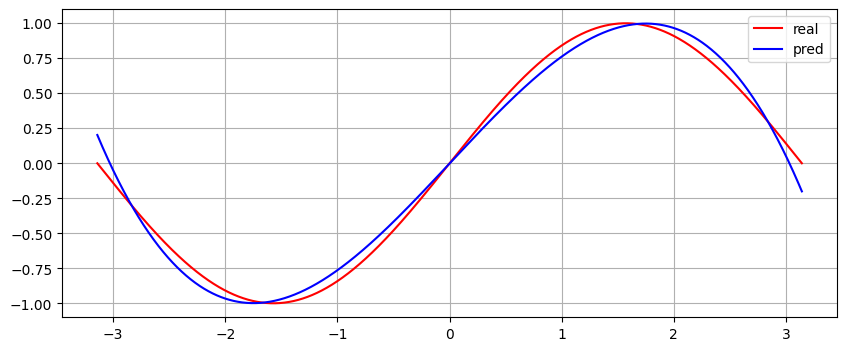

In [29]:
with torch.no_grad():
    show(x, y, a + b * x + c * x ** 2 + d * x ** 3)

##### loss.backward() 역전파 진행 순서
1. **그래프 생성** - PyTorch는 텐서 연산을 통해 계산 그래프(연산 그래프)를 동적으로 생성. 각 텐서는 그 계산을 수행하는 함수(예: 덧셈, 곱셈 등)와 연결됨됨. 텐서 간의 연산은 grad_fn 속성에 기록되어, 계산 그래프를 추적
2. **연산 그래프** - loss.backward()를 호출하면, PyTorch는 손실 함수 loss에 대한 그래디언트를 계산. 손실 값은 네트워크의 출력과 실제 값 간의 차이를 측정한 값으로, 신경망의 가중치와 편향이 손실을 최소화하도록 학습하는 과정
3. **역전파** - loss.backward()가 호출되면, 자동 미분(Autograd)이 시작. PyTorch는 loss에서부터 시작하여, 그 이전에 사용된 모든 텐서에 대해 역방향으로 그래디언트를 계산. 이때, 각 연산에 대해 해당 연산이 기여한 기울기를 계산하고, 각 텐서에 대한 그래디언트를 누적.
4. **기울기 계산** - 역전파 과정에서는 각 파라미터(가중치와 편향)에 대해 손실 함수의 기울기를 계산. 이 기울기는 requires_grad=True로 설정된 텐서에 대해서만 계산. 계산된 그래디언트는 tensor.grad 속성에 저장됨.


- **retain_graph 옵션** - retain_graph=True로 설정하면, 그래디언트 계산 후에도 계산 그래프를 유지하여 추가적인 역전파를 할 수 있게 함. 기본적으로 그래디언트를 계산한 후, 그래프는 메모리에서 해제 됨.